In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## 멀티에이전트 협업 네트워크

멀티 에이전트를 LangGraph를 활용하여 구현하는 방법입니다.  
멀티 에이전트 네트워크는 복잡한 작업을 여러 개의 전문화된 에이전트들로 나누어 처리하는 `분할 정복` 접근 방식을 사용하는 아키텍처 입니다.  
  
멀티 에이전트의 특징은 다음과 같습니다:  

- 도구 사용 로직이 복잡하지 않습니다. 
- 에이전트가 한 번에 처리해야 할 정보 양이 감소합니다.  

`분할 정복` 접근을 사용하면 각 에이전트는 특정 업무나 전문성 영역에 집중할 수 있고, 전체 작업이 네트워크 형태로 나뉘어 처리됩니다.  
각 에이전트는 자신이 잘하는 일을 처리하고, 필요 시 해당 업무를 다른 전문 에이전트에게 위임하거나 도구를 적절히 활용합니다.  
  
##### 참고자료

- [LangGraph 멀티 에이전트 네트워크 개념](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)
- [AutoGen 논문: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)

##### 그래프 흐름

![multi_agent](./assets/langgraph_use_case_multi_agent.png)

### 기능 구현

#### 모델 정의

In [29]:
from models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


#### 웹 검색 도구 정의

In [30]:
# 웹 검색 도구 초기화
from tools_tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
tavily_tool = TavilySearch(max_results=3)

#### 코드 실행 도구 정의

In [31]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


# Python 코드를 실행하는 도구 정의
python_repl = PythonREPL()


# Python 코드를 실행하는 도구 정의
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # 주어진 코드를 Python REPL에서 실행하고 결과 반환
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    # 실행 성공 시 결과와 함께 성공 메시지 반환
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### 에이전트 생성

#### Research Agent

`TavilySearch` 도구를 사용하여 연구를 수행하는 에이전트를 생성합니다. 이 에이전트는 필요한 정보를 리서치하는데 사용합니다.

In [32]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [33]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME)

# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

#### Chart Generator Agent

`PythonREPL` 도구를 사용하여 차트를 생성하는 에이전트를 생성합니다.

In [34]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""

# Chart Generator Agent 생성
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)

### 그래프 정의 

#### 1. 상태 정의

In [35]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # Agent 간 공유하는 메시지 목록
    sender: Annotated[str, "The sender of the last message"]  # 마지막 메시지의 발신자


#### 2. 노드 정의

In [36]:
from langgraph.graph import END


# Research Agent 노드 정의
def research_node(state: AgentState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )

    return AgentState(messages=[last_message])


# 차트 노드
def chart_node(state: AgentState) -> MessagesState:
    result = chart_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )

    return AgentState(messages=[last_message])


# 라우터
def router(state: AgentState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]

    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

#### 3. 엣지 설정 및 그래프 컴파일

In [37]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

#### 4. 그래프 시각화

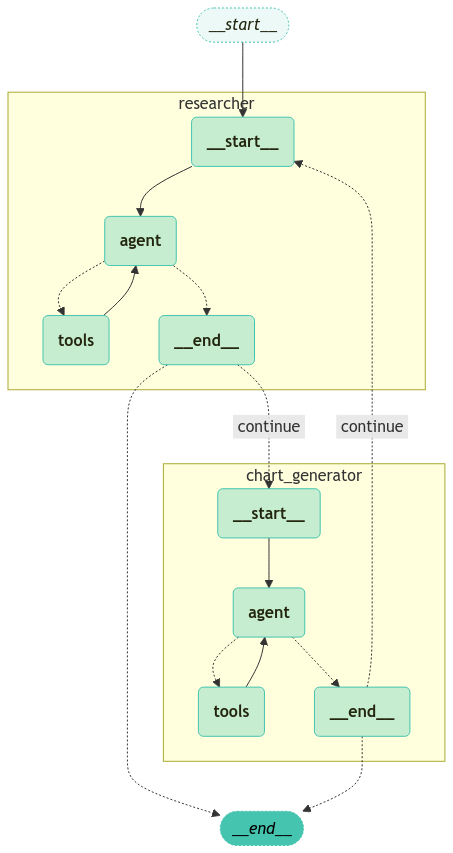

In [38]:
from graphs import visualize_graph

visualize_graph(app, xray=True)

#### 5. 실행


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_pmSCPFqYCioYvOMxipWhDk3C)
 Call ID: call_pmSCPFqYCioYvOMxipWhDk3C
  Args:
    query: Bitcoin monthly prices January to December 2024
  tavily_web_search (call_cqPX4T0oZqVE9V9ZYyCVUx5m)
 Call ID: call_cqPX4T0oZqVE9V9ZYyCVUx5m
  Args:
    query: Bitcoin price forecast 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Here are some insights and data related to Bitcoin's price forecasts for 2024:

1. **Current Price Data**: As of late 2024, Bitcoin's price has seen significant fluctuations. For example, on November 18, 2024, the price was $89,841.47, marking a notable increase from the previous years.

2. **Historical Highs and Lows**: In 2024, Bitcoin experienced its hig

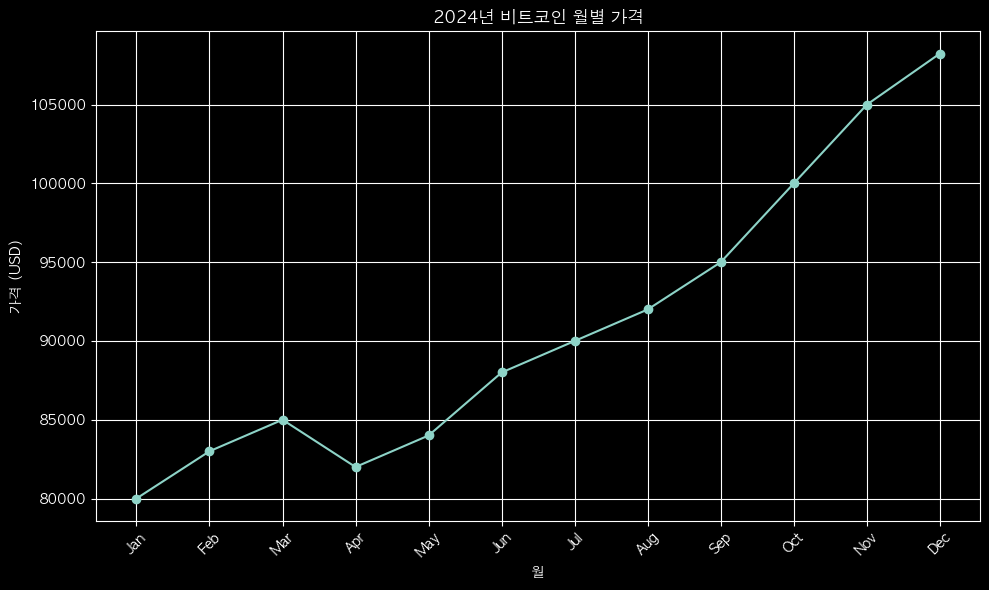


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_B2b2s0OVNoiICHOW6ZP2cDpF)
 Call ID: call_B2b2s0OVNoiICHOW6ZP2cDpF
  Args:
    code: import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# Data for Bitcoin prices in 2024
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
prices = [80000, 83000, 85000, 82000, 84000, 88000, 90000, 92000, 95000, 100000, 105000, 108244]

# Font settings based on OS
current_os = platform.system()
if current_os == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    try:
        plt.rcParams["fon

In [41]:
from langchain_core.runnables import RunnableConfig
from langchain_print import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2024년 1월부터 12월까지 비트코인 월별 가격을 그래프로 그려주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])